In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, confusion_matrix, \
                            accuracy_score, precision_score,recall_score, f1_score
pd.set_option("display.max_rows", None)

In [2]:
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
# read data
train = pd.read_csv('../Data/CMaps/train_FD001.txt',sep='\s+', header=None, names=col_names)
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [3]:
# Remove those column as we can see that it's value is not changing
cols_to_drop = ['setting_3', 's_1', 's_5', 's_6', 's_10', 's_14', 's_16', 's_18', 's_19']
train=train.drop(cols_to_drop, axis=1)
# Adding RUL (Remining Useful Life) to the train dataset
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
train = add_remaining_useful_life(train)
#train[sensor_names+['RUL']].head()
print((train.isna().sum()==0).all())
train.head(5)

True


,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


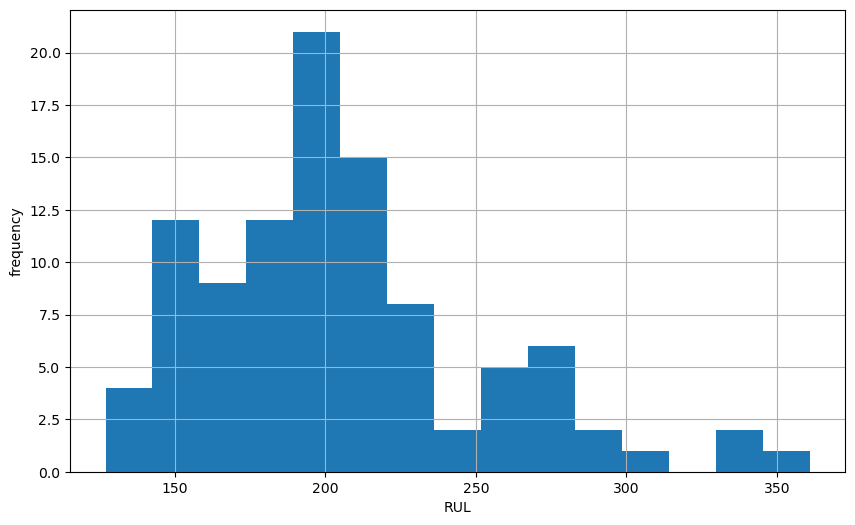

In [4]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(10,6))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [5]:
# the train data set labels are set in Class column to classify next 50 cycles 
train['class_1'] = [1 if i < 50 else 0 for i in train.RUL]
train['class_2'] = train['class_1']
train['class_2'] = np.where(train.RUL < 25, 2, train['class_2'])
print(train.shape)
train.head()

(20631, 20)


,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL,class_1,class_2
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187,0,0


In [7]:
# Splitting of Independent & Dependent Variable and train input and output data
X = train.drop(axis=0, columns=[ 'class_1', 'class_2', 'unit_nr','time_cycles','RUL'])
Y = train.class_2
# Split into training and test sets
X_train, X_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train.shape, X_validate.shape

((13822, 15), (6809, 15))

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_validate_sc = sc.transform(X_validate)
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train)
X_validate_mm = mm.transform(X_validate)

In [32]:
def train_models(X_train, y_train):
    #use logistic regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(solver='lbfgs', max_iter=200, random_state = 0)
    log.fit(X_train, y_train)
    #use KNeighbors
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2)
    knn.fit(X_train, y_train)
    #use SVC (liner kernel)
    from sklearn.svm import SVC
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_train, y_train)
    #use SVC (RBF kernel)
    from sklearn.svm import SVC
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_train, y_train)
    #use GaussianNB
    from sklearn.naive_bayes import GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train, y_train)
    #use Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train, y_train)
    #use the RandomForestClassifier
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train, y_train)
    #print the training metrics of each model
    print('[0]Logistic Regression Training Metrics: ', evaluation(log, X_train, y_train, set='traing'))
    print('[1]KNeighbors Training Metrics: ', evaluation(knn, X_train, y_train, set='traing'))
    print('[2]SVC (liner kernel) Training Metrics: ', evaluation(svc_lin, X_train, y_train, set='traing'))
    print('[3]SVC (RBF kernel) Training Metrics: ', evaluation(svc_rbf, X_train, y_train, set='traing'))
    print('[4]GaussianNB Training Metrics: ', evaluation(gauss, X_train, y_train, set='traing'))
    print('[5]Decision Tree Training Metrics: ', evaluation(tree, X_train, y_train, set='traing'))
    print('[6]RandomForestClassifier Training Metrics: ', evaluation(forest, X_train, y_train, set='traing'))
    return log, knn, svc_lin, svc_rbf, gauss, tree, forest

In [12]:
def evaluation(model, X, y, set="train"):
    y_hat = model.predict(X)
    lb = preprocessing.LabelBinarizer()
    y_lb = lb.fit_transform(y)
    y_hat_lb = lb.transform(y_hat)
    #print(y_lb, y_hat_lb)
    print(f"roc score for {set} dataset: ", roc_auc_score(y_lb, y_hat_lb, average='macro'))
    print(f'Acc Score for {set} dataset: ', accuracy_score(y_lb, y_hat_lb))
    print(f'Precision Score for {set} dataset: ', precision_score(y_lb, y_hat_lb, average='macro'))
    print(f'Recall Score for {set} dataset: ', recall_score(y_lb, y_hat_lb, average='macro'))
    print(f'f1 score for {set} dataset: ', f1_score(y_lb, y_hat_lb, average='macro'))

In [15]:
print('train metrics using standard scaler: \n')
models_sc = train_models(X_train_sc, y_train)

train metrics using standard scaler: 

roc score for traing dataset:  0.8493123586055672
Acc Score for traing dataset:  0.8993633338156563
Precision Score for traing dataset:  0.8067647089526861
Recall Score for traing dataset:  0.7806726110361923
f1 score for traing dataset:  0.7918037214309241
[0]Logistic Regression Training Metrics:  None
roc score for traing dataset:  0.8743168250854166
Acc Score for traing dataset:  0.9233830125886269
Precision Score for traing dataset:  0.872322127336571
Recall Score for traing dataset:  0.8198637735445736
f1 score for traing dataset:  0.8426823418717216
[1]KNeighbors Training Metrics:  None
roc score for traing dataset:  0.8482806978566325
Acc Score for traing dataset:  0.9004485602662422
Precision Score for traing dataset:  0.8113022998992582
Recall Score for traing dataset:  0.7796758834918375
f1 score for traing dataset:  0.7931663751494064
[2]SVC (liner kernel) Training Metrics:  None
roc score for traing dataset:  0.8582204747259793
Acc Sco

In [17]:
def print_scores(y, y_pred, model):
    print(
        'Roc: {:.02%}, Accuracy: {:.02%}, Precision: {:.02%}, Recall: {:.02%}, F1 score: {:.02%} '.format(            
            roc_auc_score(y, y_pred, average='macro'),
            accuracy_score(y, y_pred),
            precision_score(y, y_pred, average='macro'),
            recall_score(y, y_pred, average='macro'),
            f1_score(y, y_pred, average='macro')
        ), model
    )    

In [19]:
print('Validation Metrics Using Standard Scaler: \n')
for i in range(len(models_sc)):
    y_validate_hat = models_sc[i].predict(X_validate_sc)
    lb = preprocessing.LabelBinarizer()
    y_validate_lb = lb.fit_transform(y_validate)
    y_validate_hat_lb = lb.transform(y_validate_hat)        
    print_scores(y_validate_hat_lb, y_validate_lb, models_sc[i])

Validation Metrics Using Standard Scaler: 

Roc: 87.08%, Accuracy: 90.06%, Precision: 77.21%, Recall: 80.50%, F1 score: 78.58%  LogisticRegression(random_state=0)
Roc: 86.77%, Accuracy: 89.44%, Precision: 74.91%, Recall: 79.97%, F1 score: 76.94%  KNeighborsClassifier()
Roc: 87.21%, Accuracy: 90.09%, Precision: 77.08%, Recall: 80.66%, F1 score: 78.57%  SVC(kernel='linear', random_state=0)
Roc: 88.24%, Accuracy: 90.62%, Precision: 77.95%, Recall: 82.24%, F1 score: 79.83%  SVC(random_state=0)
Roc: 79.89%, Accuracy: 83.48%, Precision: 79.80%, Recall: 73.19%, F1 score: 74.89%  GaussianNB()
Roc: 81.45%, Accuracy: 86.33%, Precision: 73.36%, Recall: 73.19%, F1 score: 73.27%  DecisionTreeClassifier(criterion='entropy', random_state=0)
Roc: 86.38%, Accuracy: 89.47%, Precision: 75.16%, Recall: 79.21%, F1 score: 76.92%  RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)


In [21]:
# Final Results in the form of dataset using DT classifier
output = pd.DataFrame()
output['Expected Output'] = y_validate
output['Predicted Output'] = models_sc[-2].predict(X_validate_sc)
output.tail()

,Expected Output,Predicted Output
5617,2,2
15467,0,0
895,0,0
19644,0,0
9272,0,0


In [22]:
test = pd.read_csv('../Data/CMaps/test_FD001.txt', sep='\s+', header=None, names=col_names)
test.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [23]:
X_test = test.groupby('unit_nr').last().reset_index().drop(cols_to_drop, axis=1)
print(X_test.shape)
num_test_machines = len(X_test.unit_nr.unique())
print(num_test_machines)
X_test = X_test.drop(axis=0, columns=['unit_nr', 'time_cycles'])
print(X_test.shape)
X_test.tail()

(100, 17)
100
(100, 15)


,setting_1,setting_2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_15,s_17,s_20,s_21
95,-0.0006,0.0003,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8.4110,391,38.96,23.4606
96,0.0013,-0.0001,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8.4500,395,38.61,23.2953
97,0.0017,0.0001,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8.4235,394,38.76,23.3608
98,0.0047,-0.0000,642.00,1585.03,1397.98,554.75,2388.01,9067.16,47.26,521.82,2388.02,8.4003,391,38.95,23.3595
99,0.0013,0.0003,642.95,1601.62,1424.99,552.48,2388.06,9155.03,47.80,521.07,2388.05,8.4903,396,38.70,23.1855


In [24]:
y_true = pd.read_csv('../Data/CMaps/RUL_FD001.txt', delim_whitespace=True, names=["RUL"])
print(y_true.shape)
y_true['class_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
y_true['class_2'] = y_true['class_1']
y_true['class_2'] = np.where(y_true.RUL < 25, 2, y_true['class_2'])
print(y_true.shape)
y_true

(100, 1)
(100, 3)


,RUL,class_1,class_2
0,112,0,0
1,98,0,0
2,69,0,0
3,82,0,0
4,91,0,0
5,93,0,0
6,91,0,0
7,95,0,0
8,111,0,0
9,96,0,0


Test Metrics Using Standard Scaler: 



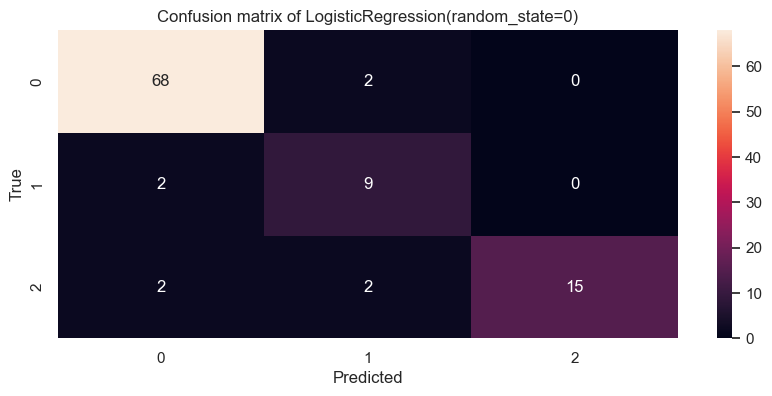

Roc: 91.59%, Accuracy: 92.00%, Precision: 85.97%, Recall: 87.89%, F1 score: 86.34%  LogisticRegression(random_state=0)


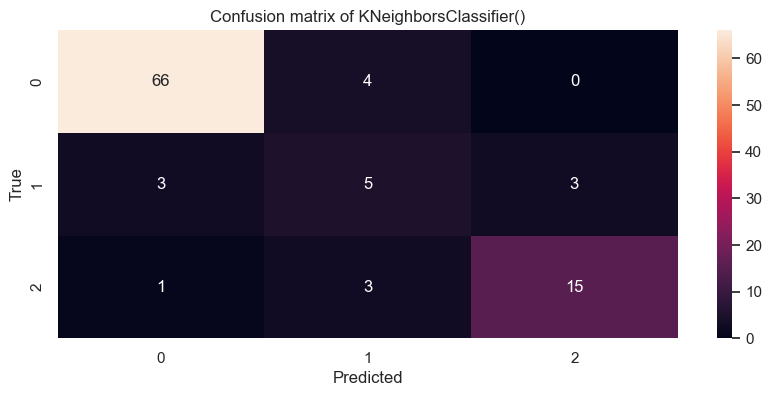

Roc: 82.38%, Accuracy: 86.00%, Precision: 72.90%, Recall: 73.10%, F1 score: 72.95%  KNeighborsClassifier()


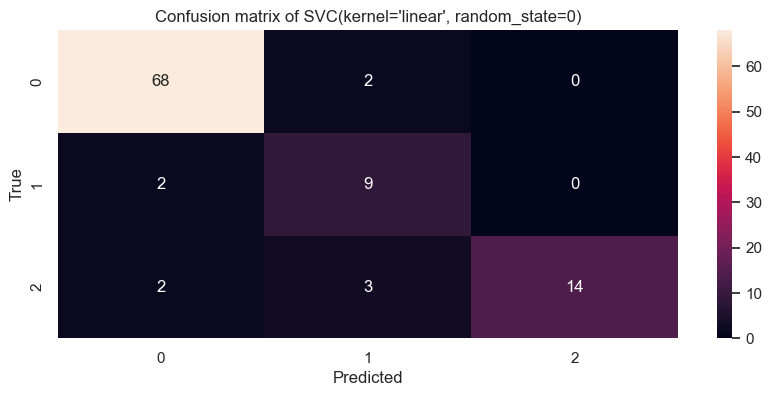

Roc: 90.57%, Accuracy: 91.00%, Precision: 84.22%, Recall: 86.24%, F1 score: 84.21%  SVC(kernel='linear', random_state=0)


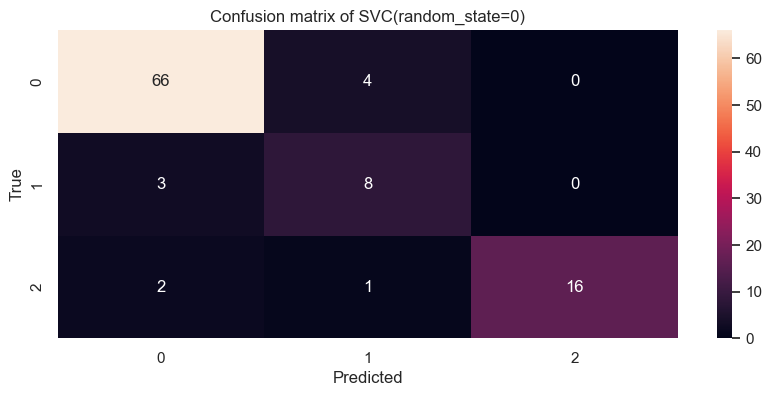

Roc: 88.95%, Accuracy: 90.00%, Precision: 83.74%, Recall: 84.83%, F1 score: 83.90%  SVC(random_state=0)


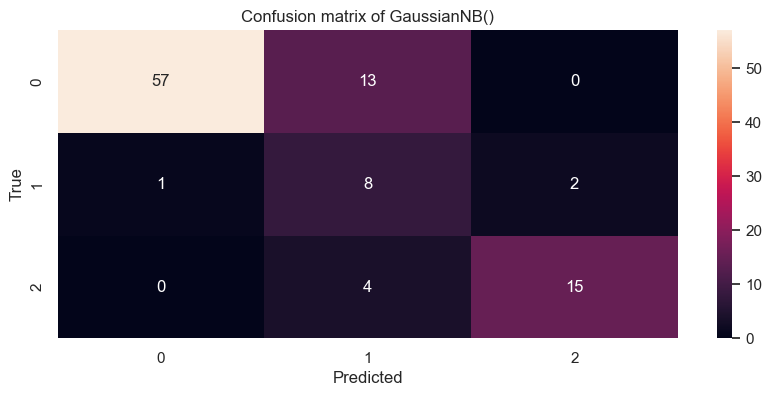

Roc: 79.79%, Accuracy: 80.00%, Precision: 77.70%, Recall: 72.84%, F1 score: 72.28%  GaussianNB()


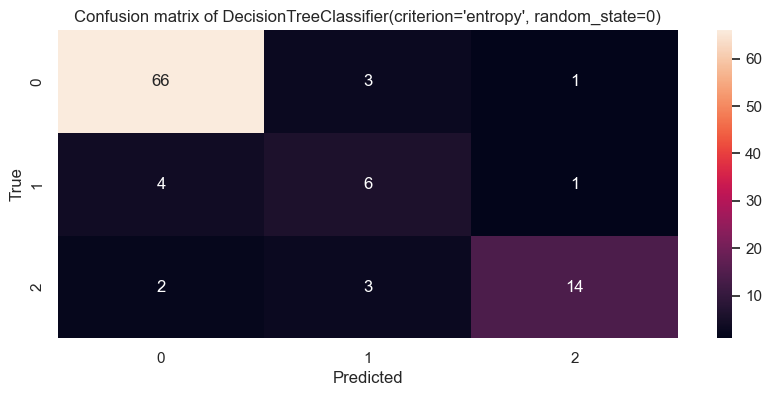

Roc: 83.87%, Accuracy: 86.00%, Precision: 74.17%, Recall: 76.39%, F1 score: 75.04%  DecisionTreeClassifier(criterion='entropy', random_state=0)


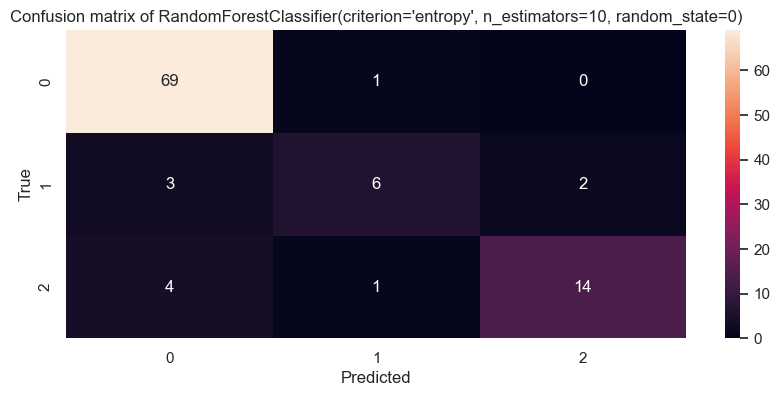

Roc: 89.62%, Accuracy: 89.00%, Precision: 75.60%, Recall: 84.43%, F1 score: 79.23%  RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)


In [27]:
print('Test Metrics Using Standard Scaler: \n')
for i in range(len(models_sc)):
    X_test_sc = sc.transform(X_test)
    y_pred = models_sc[i].predict(X_test_sc)
    y_true_lb = lb.fit_transform(y_true.class_2)
    y_pred_lb = lb.transform(y_pred)    
    cm = confusion_matrix(y_true.class_2, y_pred)
    index = ['0','1', '2']  
    columns = ['0','1', '2']  
    cm_df = pd.DataFrame(cm,columns,index)
    plt.figure(figsize=(10,4))
    sns.set(font_scale=1) # for label size
    sns.heatmap(cm_df, annot=True, fmt='g') # font size
    plt.title(f'Confusion matrix of {models_sc[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print_scores(y_pred_lb, y_true_lb, models_sc[i])

In [33]:
print('train metrics using min-max scaler: \n')
models_mm = train_models(X_train_mm, y_train)

train metrics using min-max scaler: 

roc score for traing dataset:  0.843103320929724
Acc Score for traing dataset:  0.8981334105049921
Precision Score for traing dataset:  0.8045775323192865
Recall Score for traing dataset:  0.7716811175610047
f1 score for traing dataset:  0.7849822207370187
[0]Logistic Regression Training Metrics:  None
roc score for traing dataset:  0.8660106628557052
Acc Score for traing dataset:  0.9198379395167124
Precision Score for traing dataset:  0.8671627706822812
Recall Score for traing dataset:  0.8077678229275636
f1 score for traing dataset:  0.8332262107814815
[1]KNeighbors Training Metrics:  None
roc score for traing dataset:  0.8461693505193019
Acc Score for traing dataset:  0.8998697728259297
Precision Score for traing dataset:  0.8099514607972695
Recall Score for traing dataset:  0.7764481713091215
f1 score for traing dataset:  0.790562398071839
[2]SVC (liner kernel) Training Metrics:  None
roc score for traing dataset:  0.8530704123429228
Acc Score

In [36]:
print('Validation Metrics Using Min-Max Scaler: \n')
for i in range(len(models_mm)):
    y_validate_hat = models_mm[i].predict(X_validate_mm)
    y_validate_lb = lb.fit_transform(y_validate)
    y_validate_hat_lb = lb.transform(y_validate_hat)      
    print_scores(y_validate_hat_lb, y_validate_lb, models_mm[i])

Validation Metrics Using Min-Max Scaler: 

Roc: 86.93%, Accuracy: 89.93%, Precision: 76.48%, Recall: 80.11%, F1 score: 77.96%  LogisticRegression(max_iter=200, random_state=0)
Roc: 86.34%, Accuracy: 89.06%, Precision: 73.72%, Recall: 79.27%, F1 score: 75.94%  KNeighborsClassifier()
Roc: 87.20%, Accuracy: 90.09%, Precision: 76.90%, Recall: 80.56%, F1 score: 78.40%  SVC(kernel='linear', random_state=0)
Roc: 88.11%, Accuracy: 90.54%, Precision: 77.68%, Recall: 81.98%, F1 score: 79.54%  SVC(random_state=0)
Roc: 79.89%, Accuracy: 83.48%, Precision: 79.80%, Recall: 73.19%, F1 score: 74.89%  GaussianNB()
Roc: 81.43%, Accuracy: 86.31%, Precision: 73.39%, Recall: 73.18%, F1 score: 73.28%  DecisionTreeClassifier(criterion='entropy', random_state=0)
Roc: 86.45%, Accuracy: 89.50%, Precision: 75.17%, Recall: 79.30%, F1 score: 76.96%  RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)


Test Metrics Using Min-Max Scaler: 



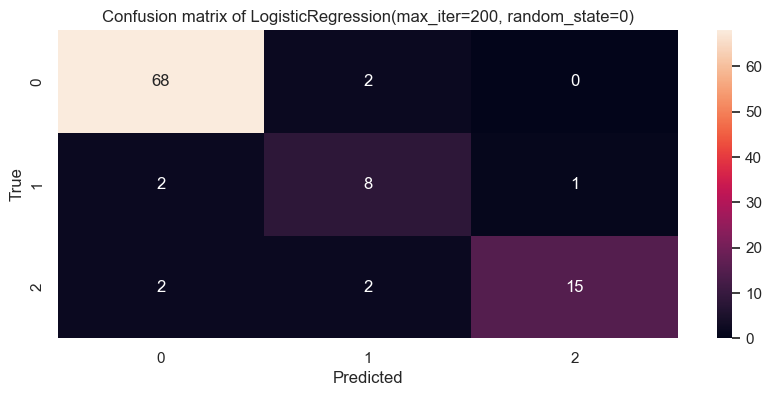

Roc: 89.92%, Accuracy: 91.00%, Precision: 82.94%, Recall: 84.95%, F1 score: 83.68%  LogisticRegression(max_iter=200, random_state=0)


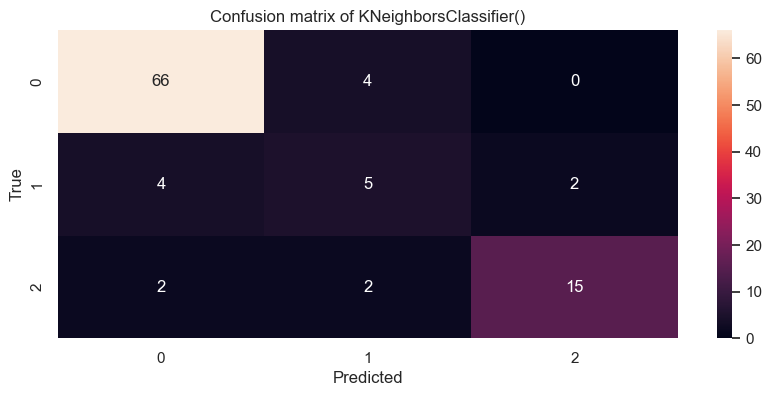

Roc: 83.25%, Accuracy: 86.00%, Precision: 72.90%, Recall: 75.12%, F1 score: 73.92%  KNeighborsClassifier()


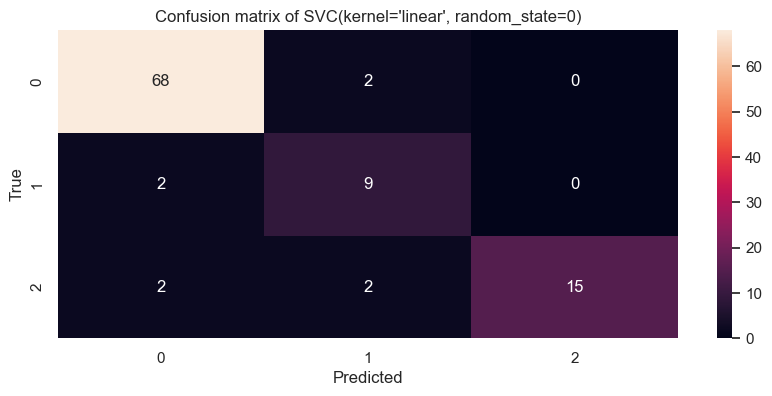

Roc: 91.59%, Accuracy: 92.00%, Precision: 85.97%, Recall: 87.89%, F1 score: 86.34%  SVC(kernel='linear', random_state=0)


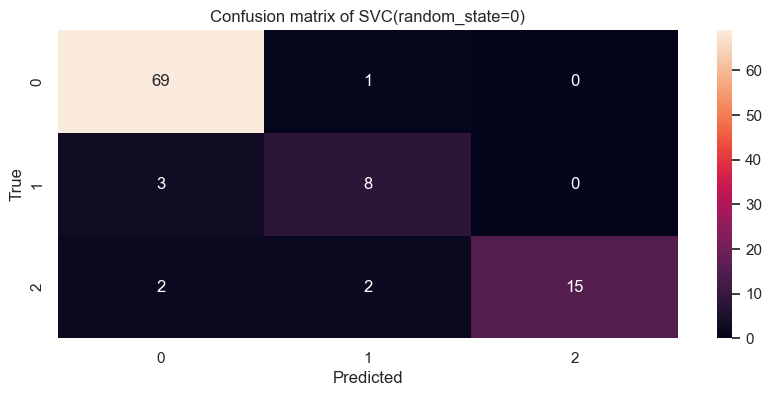

Roc: 92.34%, Accuracy: 92.00%, Precision: 83.42%, Recall: 88.66%, F1 score: 85.60%  SVC(random_state=0)


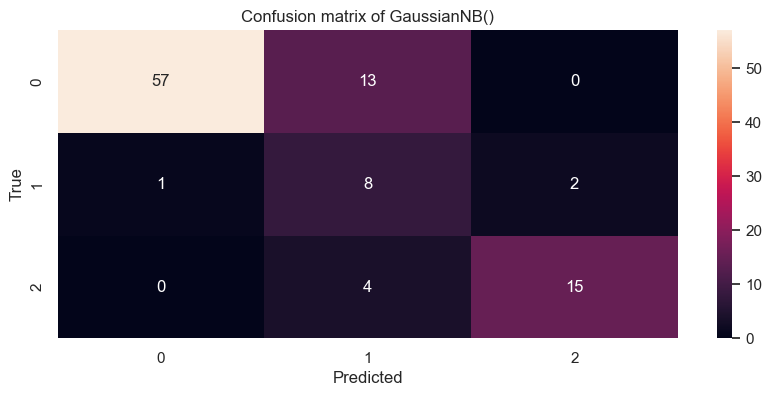

Roc: 79.79%, Accuracy: 80.00%, Precision: 77.70%, Recall: 72.84%, F1 score: 72.28%  GaussianNB()


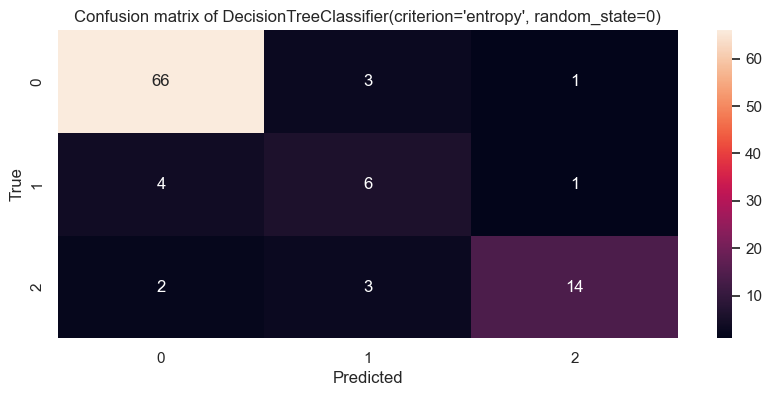

Roc: 83.87%, Accuracy: 86.00%, Precision: 74.17%, Recall: 76.39%, F1 score: 75.04%  DecisionTreeClassifier(criterion='entropy', random_state=0)


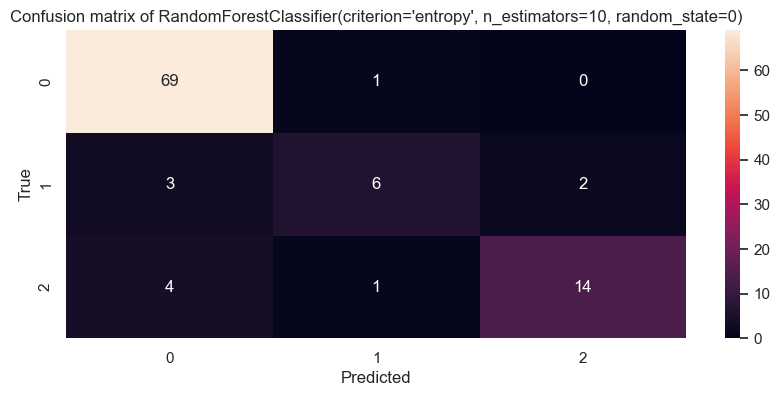

Roc: 89.62%, Accuracy: 89.00%, Precision: 75.60%, Recall: 84.43%, F1 score: 79.23%  RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)


In [37]:
print('Test Metrics Using Min-Max Scaler: \n')
for i in range(len(models_mm)):
    X_test_mm = mm.transform(X_test)
    y_pred = models_mm[i].predict(X_test_mm)
    y_true_lb = lb.fit_transform(y_true.class_2)
    y_pred_lb = lb.transform(y_pred) 
    cm = confusion_matrix(y_true.class_2, y_pred)    
    index = ['0', '1', '2']  
    columns = ['0', '1', '2']  
    cm_df = pd.DataFrame(cm,columns,index)
    plt.figure(figsize=(10,4))
    sns.set(font_scale=1) # for label size
    sns.heatmap(cm_df, annot=True, fmt='g') # font size
    plt.title(f'Confusion matrix of {models_mm[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print_scores(y_pred_lb, y_true_lb, models_mm[i])